# Assignment Part 2: Neural Net Template

This file will perform the following tasks:

- 2.1. Complete the implementation of the NN class
- 2.2. Complete the initialisation of the neural net
- 2.3. Complete the training implementation using mini-batch learning
- 2.4. Complete the testing implementation
- 2.5. Implement the rectifier activation function

### Artificial Neural Net Class

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)  # Set seed for reproducibility
random.seed(42)  # Set seed for reproducibility

# 2.1. Complete the implementation of the NN class
class ANN:

    # 2.2. Complete the initialisation of the neural net
    def __init__(self, no_inputs, hidden_layers=[300, 100, 10], max_iterations=20, learning_rate=1e-2, batch_size=250, activation='sigmoid'):

        self.no_inputs = no_inputs
        self.hidden_layers = hidden_layers
        self.max_iter = max_iterations
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.loss_tracker_train = []
        self.acc_tracker_train = []
        self.acc_tracker_test = []
        
        # Initialise weights matrices
        self.weights_matrices = []
        for layer in range(len(hidden_layers)):
            no_nodes = hidden_layers[layer]
            no_inputs_to_layer = self.no_inputs if layer == 0 else hidden_layers[layer-1]
            if self.activation == 'sigmoid':  # Using Xavier initialisation
                wm = np.random.randn(no_nodes, no_inputs_to_layer + 1) * np.sqrt(1 / (no_inputs_to_layer + 1))
            elif self.activation == 'relu':  # Using Xavier initialisation
                wm = np.random.randn(no_nodes, no_inputs_to_layer + 1) * np.sqrt(1 / (no_inputs_to_layer + 1))
            self.weights_matrices.append(wm)

    # Activation functions. Expects an array of values of shape (1,N) where N is the number of nodes in the layer.
    def activate(self, a):
        if self.activation == 'sigmoid':
            return 1/(1+np.exp(-a))  # Sigmoid activation
        elif self.activation == 'relu':
            return np.maximum(0, a)  # 2.5. Implement the rectifier activation function

    # Feed-forward prediction on batch of inputs.
    def do_predict(self, x):
        # Add bias column to the training examples
        bias_column = np.ones((x.shape[0], 1))
        x = np.hstack((x, bias_column))

        # Perform feed-forward and cache outputs of each hidden layer
        output = [None] * len(self.hidden_layers)
        for i in range(len(self.hidden_layers)):
            if i == 0:
                a = np.matmul(x, self.weights_matrices[i].T)
            else:
                prev_output = np.hstack((output[i-1], np.ones((output[i-1].shape[0], 1))))
                a = np.matmul(prev_output, self.weights_matrices[i].T)
            output[i] = self.activate(a)
        return output
    
    # Computes loss and accuracy after each epoch
    def compute_loss(self, X, labels):
        o = self.do_predict(X)[-1]  # Get final layer output
        o = np.clip(o, 1e-9, 1 - 1e-9)
        loss = -np.mean(np.sum(labels * np.log(o) + (1 - labels) * np.log(1 - o), axis=1))  # Cross-entropy loss
        return loss

    # Compute accuracy
    def compute_accuracy(self, X, labels):
        o = self.do_predict(X)[-1]  # Get final layer output
        y_pred = np.argmax(o, axis=1)
        if labels.ndim > 1:
            labels = np.argmax(labels, axis=1)
        accuracy = np.mean(y_pred == labels)
        return accuracy

    # 2.3. Complete the training implementation using mini-batch learning
    def do_train(self, training_data, labels, testing_data, testing_labels):
        assert len(training_data) == len(labels)
        
        for i in range(self.max_iter):
            if i % 10 == 0:
                print(f'Epoch [{i+1}/{self.max_iter}]')

            # Shuffle input and label data
            indices = np.arange(len(training_data))
            np.random.shuffle(indices)
            training_data, labels = training_data[indices], labels[indices]

            # Split training_data and labels into batches
            batch_size = self.batch_size
            for b in range(0, len(training_data), batch_size):
                batch_train = training_data[b:b+batch_size]
                batch_label = labels[b:b+batch_size]

                # Forward pass
                output = self.do_predict(batch_train)
                
                # Backpropagation
                gradients = [None] * len(self.hidden_layers)  # Cache the gradients for each hidden layer
                errors = [None] * len(self.hidden_layers)  # Cache the errors of each hidden layer
                
                for l in range(len(self.hidden_layers) - 1, -1, -1):  # Start from the last hidden layer and propagate backwards
                    # Compute errors in each hidden layer
                    if l == len(self.hidden_layers) - 1:    # Output layer error
                        errors[l] = output[-1] - batch_label
                    else:                                   # Hidden layer errors
                        if self.activation == 'sigmoid':
                            activation_derivative = output[l] * (1 - output[l])    # Sigmoid derivative
                        elif self.activation == 'relu':
                            activation_derivative = (output[l] > 0).astype(float)  # ReLU derivative
                        errors[l] = activation_derivative * np.matmul(errors[l + 1], self.weights_matrices[l + 1][:, :-1])  # Exclude bias term
                    
                    # Compute gradients in each hidden layer
                    if l > 0:
                        prev_output = np.hstack((output[l-1], np.ones((output[l-1].shape[0], 1))))  # Add bias
                        gradients[l] = np.matmul(errors[l].T, prev_output) / batch_size
                    else:
                        batch_train = np.hstack((batch_train, np.ones((batch_train.shape[0], 1))))  # Add bias
                        gradients[l] = np.matmul(errors[l].T, batch_train) / batch_size
                
                # Update weights
                for layer in range(len(self.weights_matrices)):
                    self.weights_matrices[layer] -= self.learning_rate * gradients[layer]

            train_loss = self.compute_loss(training_data, labels)
            train_acc = self.compute_accuracy(training_data, labels)
            test_acc = self.compute_accuracy(testing_data, testing_labels)
            self.loss_tracker_train.append(train_loss)  # Record loss per epoch
            self.acc_tracker_train.append(train_acc)  # Record accuracy per epoch
            self.acc_tracker_test.append(test_acc)  # Record accuracy per epoch

        return
    
    # Method to construct confusion matrix
    def confusion_matrix(self, predictions, labels):
        num_classes = self.hidden_layers[-1]
        cm = np.zeros((num_classes, num_classes), int)
        for i in range(len(predictions)):
            res = predictions[i]
            target = labels[i]
            cm[res, int(target)] += 1
        return cm
    
    def confusion_matrix_plot(self, cm):
        num_classes = len(cm)
        plt.figure(figsize=(num_classes * 0.6, num_classes * 0.6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
        plt.xlabel('True Label')
        plt.ylabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()
    
    # Method to calculate precision
    def precision(self, label, confusion_matrix):
        row = confusion_matrix[label, :]
        return confusion_matrix[label, label] / row.sum()
    
    # Method to calculate recall
    def recall(self, label, confusion_matrix):
        col = confusion_matrix[:, label]
        return confusion_matrix[label, label] / col.sum()

    # 2.4. Complete the testing implementation
    def test(self, testing_data, labels):
        assert len(testing_data) == len(labels)

        # Obtain predictions
        predictions = np.argmax(self.do_predict(testing_data)[-1], axis=1) # Get the index of max value (class)

        # Tabulate correct predictions and print results
        accuracy = np.mean(predictions == labels)
        cm = self.confusion_matrix(predictions, labels)
        self.confusion_matrix_plot(cm)
        print(f'Accuracy:\t{accuracy:.4f}\n')
        for i in range(self.hidden_layers[-1]):
            print(f'[Class {i}]\tPrecision: {self.precision(i, cm):.4f} | Recall: {self.recall(i, cm):.4f}')

    # Plot loss and accuracy curves
    def plot_curves(self):
        fig = plt.figure(figsize=(13, 5))

        # Plot loss curve
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(self.loss_tracker_train) + 1), self.loss_tracker_train, linestyle='-', label="Training Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Cross-entropy Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.grid()

        # Plot accuracy curve
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(self.acc_tracker_train) + 1), self.acc_tracker_train, linestyle='-', label='Training Accuracy')
        plt.plot(range(1, len(self.acc_tracker_test) + 1), self.acc_tracker_test, linestyle='-', label='Testing Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Curve')
        plt.legend()
        plt.grid()
        
        plt.show()

## 2.1. to 2.4. - Implementation of Neural Network (Binary Classification)

The following cells will train and analyse a neural network using sigmoid activation for the binary classification task in Part 1.1 - 1.3. The analysis will perform a binary classification comparison between the 2 perceptrons in Part 1 and this neural network using sigmoid activation.

### Load data:

In [210]:
print('Loading data...')

train_data = np.loadtxt("mnist_fashion_train.csv", delimiter=",")
test_data = np.loadtxt("mnist_fashion_test.csv", delimiter=",")

fac = 0.99 / 255

# Training data
X_train = np.asarray(train_data[:, 1:], dtype=np.float64) * fac + 0.01
y_train = np.asarray(train_data[:, :1], dtype=np.float64).flatten()
y_train_bi = [None] * 10
for class_label in range(10):
    y_train_bi[class_label] = np.eye(2)[np.where(y_train == class_label, 1, 0).astype(int).flatten()]  # Convert labels to binary
y_train_multi = np.eye(10)[y_train.astype(int).flatten()]  # Convert labels to onehot encodings for training

# Test data
X_test = np.asarray(test_data[:, 1:], dtype=np.float64) * fac + 0.01
y_test = np.asarray(test_data[:, :1], dtype=np.float64).flatten()
y_test_bi = [None] * 10
for class_label in range(10):
    y_test_bi[class_label] = np.where(y_test == class_label, 1, 0)  # Convert labels to binary

print('Data loaded.')

Loading data...
Data loaded.


### Training Phase:

In [219]:
net_bi = ANN(no_inputs=784, hidden_layers=[300, 100, 2], max_iterations=100, learning_rate=8e-2, batch_size=100, activation='sigmoid')
net_bi.do_train(X_train, y_train_bi[6], X_test, y_test_bi[6])

Epoch [1/100]
Epoch [11/100]
Epoch [21/100]
Epoch [31/100]
Epoch [41/100]
Epoch [51/100]
Epoch [61/100]
Epoch [71/100]
Epoch [81/100]
Epoch [91/100]


### Testing Phase:

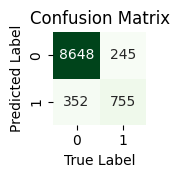

Accuracy:	0.9403

[Class 0]	Precision: 0.9725 | Recall: 0.9609
[Class 1]	Precision: 0.6820 | Recall: 0.7550
(1 above refers to Class 6 Shirts, while 0 refers to all other clothing/shoes.)


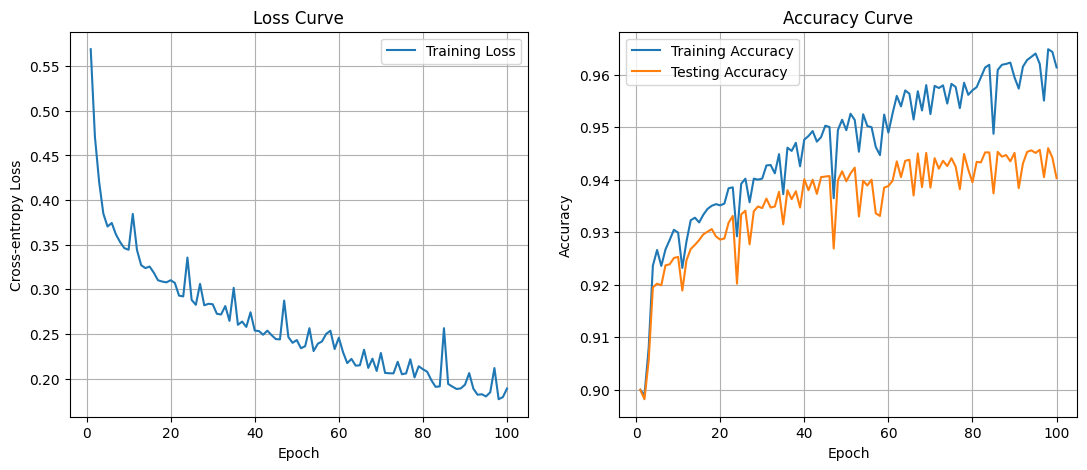

In [220]:
net_bi.test(X_test, y_test_bi[6])
print('(1 above refers to Class 6 Shirts, while 0 refers to all other clothing/shoes.)')
net_bi.plot_curves()

### Analysis (Binary Classification with sigmoid activation - Perceptron vs NN)
Back in Part 1, it was noted that the perceptrons had trouble correctly identifying Class 6 shirts, as these items bore similar visual resemblance to Classes 0, 2, and 4. As such, Class 6 was used as the basis for comparison of binary classification, to see if a multi-layer neural network could achieve better results.

Results:
- The neural network has a higher overall accuracy and much better recall and precision than both the online and full-batch perceptrons. The confusion matrix also affirms this, showing a large majority of Class 6 shirts being correctly classified as such (true positives). This is a significant improvement from the sigmoid perceptrons, both of which having very low recall scores with many False Positives and False Negatives for this class.
- This could be due to the fact that the neural network has multiple hidden layers capable of identifying abstract, higher-level features that separate Class 6 from other classes.
- In this fully-connnected NN architecture, each node of the first layer takes in all the 784 pixels of the image as input. Consequentially, these nodes are able to extract low-level features within the image comprising multiple pixels, with these features becoming more high-level in subsequent layers of the neural network.
- This would not be achievable with the single layer perceptrons, whereby each of the 784 weights take in only 1 pixel of the image as input, and therefore cannot learn anything more than a single pixel, much less higher-level features.

Modification of hyperparameters:
- Initial weights:
    - Both the perceptron and NN's weights were initialised using Xavier initialisation.
    - Firstly, both used sigmoid activation, which has an associated problem of vanishing gradients in deep neural networks, and Xavier initialisation overcomes this by ensuring that the gradients do not saturate during backpropagation.
    - Secondly, initialising the weights randomly rather than the same value would help to break symmetry and ensure that the nodes all learn differently.
    - While these reasons are more applicable for the neural network with multiple hidden layers, the Xavier initialisation was applied to the perceptron as well for consistency and comparability. Empirically, the results using randomly initialised weights without Xavier were suboptimal, so I kept to using Xavier initialisation.
- Learning rate:
    - I arrived at the respective learning rates for the perceptrons and the neural network by iteratively testing the different learning rates and using the ones with the best results. I took into consideration factors such as the quality of the convergence and the minimum-loss achieved, and tried to achieve a balance between the 2.
- Iterations: 
    - I initially set each model to 100 iterations to give them ample epochs to converge. However, I adjusted this hyperparameter upwards if more iterations were needed.
    - For the sigmoid/online perceptron, convergence was reached around 70 epochs
    - For the sigmoid/batch perceptron, convergence still had not reached after 300 epochs. Since the training and test accuracy curves do not seem to plateau yet as shown from the accuracy curve, it would take many more iterations before it converges.
    - For the sigmoid neural network, convergence was reached after 100 epochs. Thereafter, the training accuracy kept increasing while test accuracy plateaued, meaning it was starting to overfit and should stop after 100 epochs.

Training time:
- The neural network took a significantly longer time (9 mins compared to 2.5 mins) to train compared to the perceptrons, for the same number of epochs.
- This is mainly due to the fact that with fully connected neural network, each node from the previous layer is connected to each node in the next layer, resulting in a tremendous number of weights between each layer.
- In the case on this model, the number of weights after the first layer alone would be 785 x 300 = 235,500 weights, which is already significantly more than the single layer perceptron of 785 x 1 = 785 weights.
- Moreover, the neural network also need to compute and cache the activations and outputs during the feedforward, and compute the gradients for each layer during backpropagation. This would also significantly increase the time required to train the network.

Learning convergence:
- From the loss curves plotted, the neural network converged quicker than the full-batch perceptron, but slower than the online perceptrons. This is to be expected, since the mini-batch training updates the weights once every mini-batch, which is something in-between individual training data and a full-batch.
- The full-batch loss curve has a completely stable descent. On the other hand, the loss curves of the online perceptron and mini-batch neural network contain fluctuations between epochs, although there is still a noticeable downward trend. This is due to the weights being updated for each or a handful of training examples instead of the entire batch. 
- Furthermore, the learning rate for the online perceptron had to be set extremely low (1e-4), otherwise the learning curve fluctuations would appear way more pronounced.

## 2.5. Implement the rectifier activation function

The following cells will train and analyse 2 neural networks (1 using sigmoid activation and the other using ReLU activation) for a multi-class classification task. The analysis will compare between the 2 types of activations.

### Training Phase:

(1) Sigmoid

In [215]:
net_multi_sigmoid = ANN(no_inputs=784, hidden_layers=[512, 256, 10], max_iterations=100, learning_rate=5e-1, batch_size=100, activation='sigmoid')
net_multi_sigmoid.do_train(X_train, y_train_multi, X_test, y_test)

Epoch [1/100]
Epoch [11/100]
Epoch [21/100]
Epoch [31/100]
Epoch [41/100]
Epoch [51/100]
Epoch [61/100]
Epoch [71/100]
Epoch [81/100]
Epoch [91/100]


(2) ReLU

In [216]:
net_multi_relu = ANN(no_inputs=784, hidden_layers=[512, 256, 10], max_iterations=100, learning_rate=8e-2, batch_size=100, activation='relu')
net_multi_relu.do_train(X_train, y_train_multi, X_test, y_test)

Epoch [1/100]
Epoch [11/100]
Epoch [21/100]
Epoch [31/100]
Epoch [41/100]
Epoch [51/100]
Epoch [61/100]
Epoch [71/100]
Epoch [81/100]
Epoch [91/100]


### Testing Phase:

(1) Sigmoid

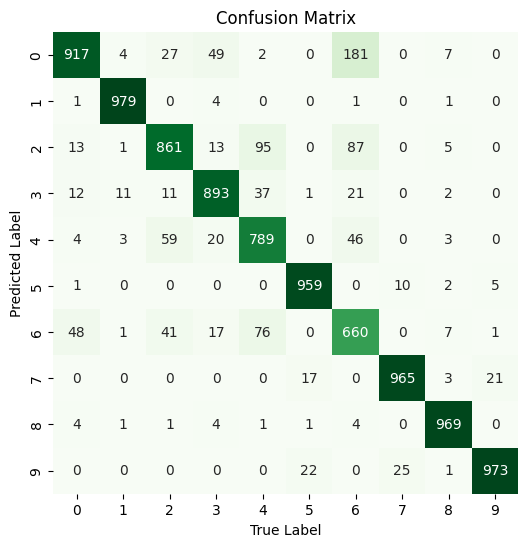

Accuracy:	0.8965

[Class 0]	Precision: 0.7725 | Recall: 0.9170
[Class 1]	Precision: 0.9929 | Recall: 0.9790
[Class 2]	Precision: 0.8009 | Recall: 0.8610
[Class 3]	Precision: 0.9038 | Recall: 0.8930
[Class 4]	Precision: 0.8539 | Recall: 0.7890
[Class 5]	Precision: 0.9816 | Recall: 0.9590
[Class 6]	Precision: 0.7756 | Recall: 0.6600
[Class 7]	Precision: 0.9592 | Recall: 0.9650
[Class 8]	Precision: 0.9838 | Recall: 0.9690
[Class 9]	Precision: 0.9530 | Recall: 0.9730


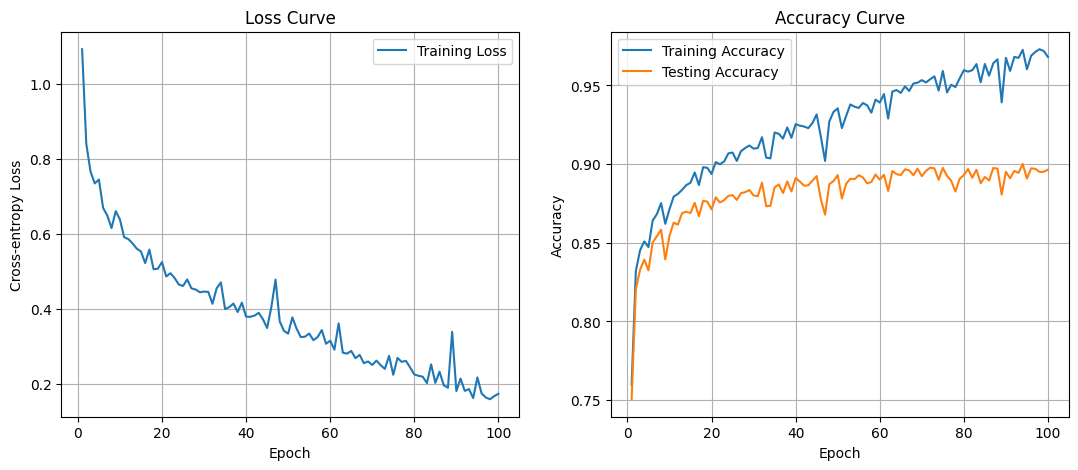

In [217]:
net_multi_sigmoid.test(X_test, y_test)
net_multi_sigmoid.plot_curves()

(2) ReLU

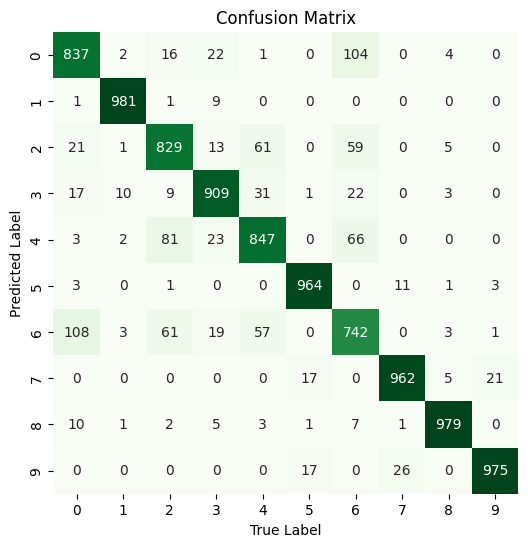

Accuracy:	0.9025

[Class 0]	Precision: 0.8489 | Recall: 0.8370
[Class 1]	Precision: 0.9889 | Recall: 0.9810
[Class 2]	Precision: 0.8382 | Recall: 0.8290
[Class 3]	Precision: 0.9072 | Recall: 0.9090
[Class 4]	Precision: 0.8288 | Recall: 0.8470
[Class 5]	Precision: 0.9807 | Recall: 0.9640
[Class 6]	Precision: 0.7465 | Recall: 0.7420
[Class 7]	Precision: 0.9572 | Recall: 0.9620
[Class 8]	Precision: 0.9703 | Recall: 0.9790
[Class 9]	Precision: 0.9578 | Recall: 0.9750


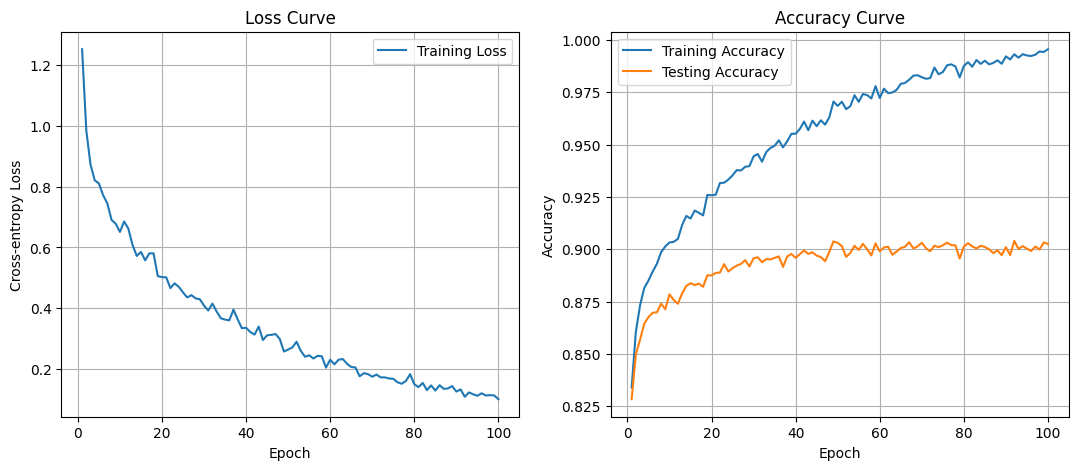

In [218]:
net_multi_relu.test(X_test, y_test)
net_multi_relu.plot_curves()

### Analysis (Multi-class Classification NN comparison - sigmoid vs ReLU)
Results:
- The neural networks achieved very similar results, with ReLU slightly outperforming sigmoid.
- As observed from the accuracy curves, ReLU achieved convergence at approximately 90% test accuracy, with sigmoid achieving convergence slightly under that.
- Furthermore, both neural networks have much better accuracy at classifying Class 6 correctly, as observed from the improved precision and recall scores. However, ReLU appears to be better than sigmoid at this.
- From a performance standpoint, this shows that sigmoid and ReLU neural networks can achieve a very similar level of learning optimisation on this particular dataset, with ReLU having a slight edge over sigmoid.

Selection of hyperparameters:
- Initial weights: 
    - Both the sigmoid and ReLU neural networks were initialised using Xavier initialisation. Conventionally, He initialisation would be a more appropriate initialisation for ReLU neural networks. However, its accuracy and convergence did not show any improvement over Xavier initialisation after testing it using various hyperparameter combinations. Hence, I kept to using Xavier initialisation for better results and comparability.
- Learning rate:
    - I arrived at the respective learning rates for the neural network by iteratively testing the different learning rates and using the ones with the best results.
    - It can be noted that the sigmoid neural network performed best with higher learning rates, as opposed to the ReLU neural network which performed best with lower learning rates.
    - This is because sigmoid activation has an associated vanishing gradient problem, and hence higher learning rates work better. Whereas, ReLU activation conventionally suffers from exploding gradient problem, and hence lower learning rates are better suited. In fact, learning rates with more than 1e-1 kept resulting in errors in the ReLU neural network training.
- Number and size of layers:
    - I had tested several neural network architectures:
        - Default: [784, 300, 100, 10] - approx. 266k weights
        - Broad: [784, 512, 256, 10] - approx. 535k weights
        - Deep: [784, 300, 250, 200, 100, 10] - approx. 381k weights
        - Mixed: [784, 512, 256, 128, 10] - approx. 567k weights
    - The best accuracy result (~90% for both sigmoid and ReLU) I obtained was from the broad [784, 512, 256, 10] and mixed [784, 512, 256, 128, 10] hidden layer architectures.
    - However, this was only marginally better (less than 1% improvement) than the next best result by the default [784, 300, 100, 10], and it took twice as long to train due to the huge increase in number of weights trained.
    - The deeper network architecture of [784, 300, 250, 200, 100, 10] did not result in significantly better accuracy, even though the number of weights increased somewhat substantially over the default architecture [784, 300, 100, 10].
    - The increase in accuracy only seemed to arise from the increase in number of nodes within each layer, rather than increasing the number of hidden layers in the network. This suggests that a 3-hidden-layer neural network architecture might be sufficient to capture most of the image features in the Fashion MNIST dataset, since these 28x28 greyscale images may not be a very complex dataset in the first place.
    - Perhaps it is more crucial for this dataset that there are enough nodes to capture the low level features in the first hidden layer, rather than more layers and nodes in the deeper layers that capture higher level features.
    - Still, the improvement in accuracy goes to show that deeper and broader neural networks may enable better extraction of features. 
- Iterations:
    - 100 epochs was used as to give sufficient iterations for all the different models to converge towards the minimum.
    - However, upon analysing the accuracy curves, it appears that the test accuracies have started to plateau around epoch 60 to 70 while the training accuracy continues to increase. This means that the model is beginning to overfit and hence training should ideally stop at epoch 70.
- Training time:
    - The sigmoid neural network took 15.5 mins to train as compared to the ReLU neural network which only took 13 mins.
    - This can be attributed to the computational cost of calculating the exponential e^(-a) in the sigmoid activation function, and hence would take significantly more time. On the other hand, the ReLU activation is simply a conditional check if the activation is less than or equal to zero.
    - Likewise during backpropagation, computing the sigmoid derivative requires computing the exponential again, while ReLU is simply another conditional check.
- Learning convergence:
    - It can be observed from the accuracy curves that sigmoid neural network took longer than ReLU neural network to converge (70 epochs vs 50 epochs).
    - This could be due to the nature of the sigmoid activation, which forces inputs into the range of 0 to 1. If the inputs are very positive or negative, this would cause the gradients to vanish in deeper neural networks, leading to slower learning.
    - This might be a problem for much deeper neural networks, but since the models used above are only 3-4 hidden layers deep, the difference is a non-issue in this case.